In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Import des librairies utiles 
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
import seaborn as sns
from datetime import datetime as dt
import pickle


In [ ]:
cat_list = os.listdir("/content/gdrive/MyDrive/Interface_E2/clean_dataset/train/cat")
dog_list = os.listdir("/content/gdrive/MyDrive/Interface_E2/clean_dataset/train/dog")
print("Le nombre d'images d'entrainement de chat est de : " + str(len(cat_list)))
print("Le nombre d'images d'entrainement de chien est de : " + str(len(dog_list)))

Le nombre d'images d'entrainement de chat est de : 9987
Le nombre d'images d'entrainement de chien est de : 9985


In [ ]:
# En raison de limitations computationnelles nous ne prendrons que 5000 images par catégories pour l'entrainement 
cat_train = cat_list[:5000]
dog_train = dog_list[:5000]
print("Pour la catégorie chat on utilisera " + str(len(cat_train)) + " images.")
print("Pour la catégorie chien on utilisera " + str(len(dog_train)) + " images.")

Pour la catégorie chat on utilisera 5000 images.
Pour la catégorie chien on utilisera 5000 images.


In [ ]:
# Actuellement nous avons deux liste séparées que nous devons réunir en une unique liste de données d'entrainement. 
# On utilise la méthode extend() qui concatènera les deux liste à la suite 
# On utilisera donc np.random.shuffle() pour randomiser le jeu de données d'entrainement. 
train_list = []
train_list.extend(cat_train)
train_list.extend(dog_train)
np.random.shuffle(train_list)

In [ ]:
# On vérifie la nature de train_list obtenue et on s'assure de la randomisation des données en visualisant les 10 premiers éléments de la liste
train_list[:10]

['dog.2281.jpg',
 'cat.2515.jpg',
 'dog.10606.jpg',
 'cat.5807.jpg',
 'cat.3751.jpg',
 'dog.11873.jpg',
 'cat.11045.jpg',
 'dog.10377.jpg',
 'dog.3951.jpg',
 'dog.8626.jpg']

In [ ]:
# On remarque que cette liste contient uniquement le nom du fichier. 
# Le modèle de régression logistique le n'accepte que des valeurs numériques et non pas des images au format .jpg. 
# Pour convertir les images au format numérique, il faut considérer 2 éléments qui sont la taille de l'image (hauteur, largeur) et l'encodage de la couleur au format RGB donc 3 canaux. 
# Or, on a observé durant la phase de nettoyage que les images n'avaient pas de taille standard. 
# Il est donc nécessaire d'implémenter une étape de redimensionnement des images de sortes qu'elles aient toute une taille standard. 
# Il est admis que plus une image a une taille réduite plus l'apprentissage est rapide. On décide donc de redimensionner les images au format 100x100x3 
# On initialise donc un vecteur qui aura pour dimension (10000, 100*100*3). 
# En effet, les 10000 images d'entrainements seront assignées à ce vecteur une fois qu'elles auront été redimensionnées. 
X_train = np.zeros((10000, 100*100*3))

In [ ]:
# On doit redimensionner l'ensemble des images d'entrainement à l'aide de la fonction resize() et crop()
# La fonction redim prend en paramètre ke chemin de l'image et la taille et renvoie une image redimensionnée depuis le centre avec la taille spécifiée
def redim(image_path, size): 
  img = Image.open(image_path)
  img = img.resize((size+1, size+1))
  x_center = img.width/2
  y_center = img.height/2
  size = size/2
  redim_img = img.crop((x_center-size, y_center-size, x_center+size, y_center+size))
  return redim_img 

In [ ]:
# On applique la fonction redim() à l'ensemble des images dans train_list
# Une fois redimensionnées, on les transforme en vecteur grâce à la fonction np.array()
# Puis on remplace le vecteur vide de l'image dans X_train par le vecteur de l'image ainsi prétraitée. 
for i, image_name in enumerate(train_list): 
  if image_name.split(".")[0] == "dog":
    path = "/content/gdrive/MyDrive/Interface_E2/clean_dataset/train/dog"
  else: 
    path = "/content/gdrive/MyDrive/Interface_E2/clean_dataset/train/cat"
  image_path = f'{path}/{image_name}'
  resized_img = redim(image_path, 100)
  resized_array_img = np.array(resized_img).reshape(-1)
  X_train[i] = resized_array_img

In [ ]:
# On vérifie les dimensions du vecteur qui devraient être de 10 000 par 30 000
X_train.shape

(10000, 30000)

In [ ]:
# On vérifie que les vecteurs d'images ont bien été remplacé dans le vecteur vide
# On observe les valeurs de X_train[0]
X_train[0]

array([165., 153., 137., ..., 133., 119.,  88.])

In [ ]:
# On normalize les images. Cette étape consiste à diviser par 255 l'ensemble du vecteur. 
# Ainsi, on on obtient des vecteurs avec des valeurs de pixels par image comprise entre 0 et 255. 
# Cette étape permet notamment de réduire la durée d'apprentissage tout en maintenant le rapport entre les différentes valeurs de pixels
X_train = X_train/255

In [ ]:
# Nos données d'entrainement sont maintenant prête. 
# Cependant, nous sommes dans un cas d'apprentissage supervisé, il nous faut donc récolter les labels de chaque image présente dans X_train
# Pour cela on doit passer d'une liste de nom de fichier à une liste de label. 
# Nos images contiennent dans leur nom de fichier le label. 
# On utilise donc la méthode split() et la méthode de list comprehension en Python 
# On rappelle que la catégorie chat = 0 et la catégorie chien = 1 
Y_train = np.array([0 if name.split(".")[0]=="cat" else 1 for name in train_list])

In [ ]:
# On vérifie que les labels obtenu correspondent bien aux images. 
# On visualise les 10 premiers labels de Y_train et vérifie leur bonne correspondance avec les 10 premières images de X_train. 
Y_train[:10]

array([1, 0, 1, 0, 0, 1, 0, 1, 1, 1])

In [ ]:
# On vérifie que Y_train contient bien autant de label que nous avons d'images d'entrainement soit : 10 000
Y_train.shape

(10000,)

In [ ]:
# À présent nos images d'entrainement ont été converties en vecteur de pixels, les valeurs des pixels ont été normalisées
# et les labels ont été récupérés : notre jeu d'entrainement est prêt pour alimenter le modèle
model = LogisticRegression(max_iter=1000, solver = 'liblinear', penalty='l2', verbose=1)


In [ ]:
# On peut mettre un timer pour avoir une estimation du temps de l'apprentissage 
start = dt.now()
model.fit(X_train, Y_train)
running_secs = (dt.now()-start).seconds

[LibLinear]

In [ ]:
# On sauvegarde le modèle à l'aide de pickle 
filename = "Log_Reg_10000.sav"
pickle.dump(model, open(filename, 'wb'))

In [ ]:
# On évalue les performances du modèle sur le jeu de données d'entrainement 
train_pred = model.predict(X_train)
cm = confusion_matrix(train_pred, Y_train)
cm

array([[4991,    4],
       [   9, 4996]])

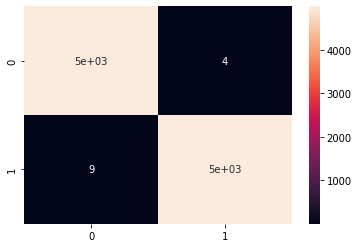

In [ ]:
# On plot la matrice de confusion 
sns.heatmap(cm, annot=True)

In [ ]:
# On doit maintenant évaluer le modèle sur le set de validation. 
# Etant donné qu'on a 10 000 images d'entrainement, on validera sur un échantillon de 2000 images soit 20%
# On aura donc 1000 images de chat et 1000 images de chien à classifier
val_list_dog = os.listdir("/content/gdrive/MyDrive/Interface_E2/clean_dataset/validation/dog")
val_list_cat = os.listdir("/content/gdrive/MyDrive/Interface_E2/clean_dataset/validation/cat")
print("Le nombre d'images de validation de chat est de : " + str(len(val_list_cat)))
print("Le nombre d'images de validation de chien est de : " + str(len(val_list_dog)))

Le nombre d'images de validation de chat est de : 1248
Le nombre d'images de validation de chien est de : 1248


In [ ]:
# On ne sélectionne que 1000 images dans chaque catégorie puis on créer une nouvelle liste comme précédemment 
val_list_dog = val_list_dog[:1000]
val_list_cat = val_list_cat[:1000]
val_list = []
val_list.extend(val_list_dog)
val_list.extend(val_list_cat)

In [ ]:
# On vérifie que val_list contiennent bien 2000 images 
len(val_list)

2000

In [ ]:
# On recréer la matrice des images avec les données de validation 
X_val = np.zeros((2000, 100*100*3))

In [ ]:
for i, image_name in enumerate(val_list):
    if image_name.split(".")[0] == "dog":
        path =  "/content/gdrive/MyDrive/Interface_E2/clean_dataset/validation/dog"
    else:
        path =  "/content/gdrive/MyDrive/Interface_E2/clean_dataset/validation/cat"
    image_path = f'{path}/{image_name}'
    crp_img = redim(image_path,100)
    crp_arr = np.array(crp_img).reshape(-1)
    X_val[i] = crp_arr

In [ ]:
# On normalize les valeurs des pixels 
X_val = X_val/255

In [ ]:
# On récupère les lables des images de validation 
val_labels = np.array([0 if name.split(".")[0]=="cat" else 1 for name in val_list])

In [ ]:
# On lance les prédiction sur le jeu de validation et on calcule la matrice de confusion
val_pred = model.predict(X_val)
cm_val = confusion_matrix(val_pred, val_labels)
cm_val 

array([[602, 506],
       [398, 494]])

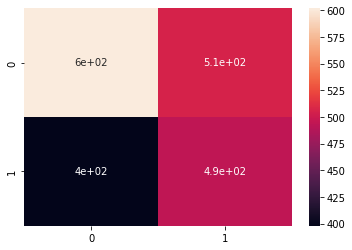

In [ ]:
# On plot la matrice de confusion sur les données de validation 
sns.heatmap(cm_val, annot=True)

In [ ]:
# En complément de la matrice de confusion on peut analyser la précision, le recall et le f1-score. 
# L'ensemble de ces métriques peuvent être obtenues avec la méthode classification_report()
# On enregistre le rapport dans un dataframe qu'on peut exposert au format csv 
report = classification_report(val_labels, val_pred, output_dict=True)

In [ ]:
df = pd.DataFrame(report).transpose()

In [ ]:
df

,precision,recall,f1-score,support
0,0.543321,0.602,0.571157,1000.000
1,0.553812,0.494,0.522199,1000.000
accuracy,0.548000,0.548,0.548000,0.548
macro avg,0.548566,0.548,0.546678,2000.000
weighted avg,0.548566,0.548,0.546678,2000.000


In [ ]:
df.to_csv('classification_report.csv')

In [ ]:
# Interprétation : 
# Précision : 
# Parmi les 1000 chats et 1000 chiens que le modèle a prédit seulement 54.3% étaient vraiment des chats et 55.4% étaient vraiment des chien. 
# Recall : Parmi les 1000 images qui étaient vraiment des chats, le modèle a prédit correctement à 60.2% les chats 
# Parmi les 1000 images qui étaient vraiment des chiens, le modèle a prédit correctement à 49.4% les chiens.
# F1-Score : Cette valeur est assez éloignée de 1 : Le modèle a donc réaliser une prédiction pauvre. 

In [ ]:
# Un autre indicateur de performance qu'on peut étudier est la courbe ROC
no_learn = [0 for _ in range(len(val_labels))]

In [ ]:
 # On prédit la probabilité des images de validation 
learn_probs = model.predict_proba(X_val)

# On ne garde que les probabilité de la classe 1 
learn_probs = learn_probs[:, 1]

# On calcule les score 
nl_auc = roc_auc_score(val_labels, no_learn)
lr_auc = roc_auc_score(val_labels, learn_probs)

# Résume les score 
print("No Skill: ROC AUC=%.3f" % (nl_auc))
print("Logistic: ROC AUC=%.3f" % (lr_auc))

# Calcule les courbes ROC 
ns_fpr, ns_tpr, _ = roc_curve(val_labels, no_learn)
lr_fpr, lr_tpr, _ = roc_curve(val_labels, learn_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label="No Skill")
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrai positifs')
plt.legend()
plotfile = 'Courbe_ROC_Reg_Log'
plt.savefig(plotfile + '_plot.png')
plt.close()

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.569


In [ ]:
# On peut essayer d'améliorer ce modèle soit en testant la cross validation 
# Soit en faisant de la data augmentation. 
